## Feature Extaction Test

In [3]:
import sys
sys.path.insert(0, '..')
from metrics.metrics import get_tp_fp_fn, quick_circle_comparison, circle_comparison
from general_utils.plots import plot_bboxes_over_image, simple_im_show, simple_im_show2
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from feature_extraction.feature_extraction import CandidatesFeatureExtraction
from database.dataset import *

import pickle

### Database initialization

In [4]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=1000000.,
    # This is not working as you want since last update, to do so include validation
    partitions=['train', 'validation'],
    extract_patches=False,
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,
)


### Detectors Parameters and initialization

In [5]:
hd = HoughCalcificationDetection()

path = (Path.cwd().parent / f'feature_extraction/haar_features/')
with open(path/'final_feat_selection.p', 'rb') as f:
    selection = pickle.load(f)

# ISTANTIATE the candidate Feature Extractor with the selected features.
haar_params = {
    'skimage': {
        'feature_type': selection['skimage_haar_feature_types_sel'],
        'feature_coord': selection['skimage_haar_feature_coords_sel']
    },
    'ours': {
        'horizontal_feature_selection': selection['hor_feats_selection'].tolist(),
        'rotated_feature_selection': selection['rot_feats_selection'].tolist(),
        'rotated_feature_types': None,
        'horizontal_feature_types': None
    },
    'patch_size': 14
}

### Detector initialization

In [6]:
# FE class initialization
gabor_params = {'scale': 2, 'orientation': 3,
                    }
wavelet_params = {'angles': [0]}

cfe = CandidatesFeatureExtraction(patch_size=14, fos=True, gabor_params=gabor_params, wavelet_params=wavelet_params, center_crop_size=7, haar_params=haar_params)


### FE

In [5]:
fdf = []
for idx in tqdm(range(len(db))):
    # extracting data
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db.df.iloc[idx].img_id
    image_mask = db_sample['lesion_mask']

    # candidate selection
    _, h2_circles = hd.detect(
        image, image_id, load_processed_images=True, hough2=True)

    # feature extraction
    res = pd.DataFrame(cfe.extract_features(
        h2_circles, image, image_mask, fp2tp_sample=None), columns=cfe.feature_names)
    res['img_id'] = image_id

    fdf.append(res)

all_data_df = pd.concat(fdf)

100%|██████████| 167/167 [37:40<00:00, 13.54s/it]


In [6]:
all_data_df.to_pickle('allfs_10000maxlessize_hough2.pkl')

In [5]:
fdf = []
for idx in tqdm(range(len(db))):
    # extracting data
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db.df.iloc[idx].img_id
    image_mask = db_sample['lesion_mask']

    # candidate selection
    h1_circles, _ = hd.detect(
        image, image_id, load_processed_images=True, hough2=False)

    # feature extraction
    res = pd.DataFrame(cfe.extract_features(
        h1_circles, image, image_mask, fp2tp_sample=None), columns=cfe.feature_names)
    res['img_id'] = image_id

    fdf.append(res)

all_data_df = pd.concat(fdf)

100%|██████████| 167/167 [57:03<00:00, 20.50s/it]


In [6]:
all_data_df.to_pickle('allfs_10000maxlessize_hough1.pkl')

### Classification

In [6]:
from sklearn.svm import SVC

from sklearn.metrics import f1_score, roc_auc_score

from sklearn.preprocessing import MinMaxScaler


In [19]:
all_data_df = pd.concat(fdf).sample(frac=1)  # merge and shuffle
data = all_data_df.drop(columns=['patch_coordinates'])
data.head(10)


,img_energy,img_entropy,img_uniformity,img_min,img_10th_perc,img_90th_perc,img_max,img_mean,img_median,img_inter_quartile_range,...,patch_glcm_homogeneity_HH1_0,patch_glcm_contrast_LH1_0,patch_glcm_contrast_HL1_0,patch_glcm_contrast_HH1_0,patch_glcm_dissimilarity_LH1_0,patch_glcm_dissimilarity_HL1_0,patch_glcm_dissimilarity_HH1_0,candidate_coordinates,center_patch_mask_intersection,img_id
10,45.519469,6.854848,0.009788,0.45177,0.462882,0.500855,0.520635,0.4817,0.481197,0.019719,...,6271.771429,63.428571,0.169031,-0.070601,0.004692,5599.885714,58.057143,"[22, 571, 17]",0,24065680
17,50.621714,6.884819,0.009736,0.448808,0.491445,0.52763,0.541094,0.507949,0.507574,0.02209,...,6643.2,73.085714,0.169031,-0.017585,0.001759,8012.571429,74.971429,"[848, 1522, 9]",0,22678810
156,54.494071,6.851506,0.009683,0.47048,0.499631,0.552952,0.572694,0.52686,0.528044,0.032657,...,8277.685714,76.428571,0.169031,0.156355,0.009905,7318.228571,66.8,"[932, 1251, 19]",0,22613676
130,67.712141,6.9877,0.008955,0.53276,0.558181,0.617615,0.667741,0.587297,0.585213,0.028375,...,10581.742857,81.342857,0.169031,0.175195,0.020545,5458.4,62.571429,"[297, 2485, 4]",0,22670177
176,60.223862,6.668673,0.011297,0.486774,0.535819,0.576414,0.590007,0.554044,0.554004,0.023237,...,7261.628571,70.657143,0.169031,0.02859,0.002931,6958.571429,65.657143,"[2, 1906, 7]",0,20587994
3,93.72753,6.509391,0.012963,0.649883,0.6669,0.711888,0.738462,0.691294,0.693473,0.021911,...,4094.228571,51.828571,0.173793,0.033586,0.034394,5508.2,57.857143,"[516, 1500, 3]",0,20587466
49,80.730537,6.758518,0.010308,0.597894,0.621257,0.662718,0.685094,0.641581,0.639684,0.023774,...,4201.857143,53.057143,0.169031,-0.01364,0.001806,7537.314286,74.857143,"[343, 1702, 19]",0,26933830
24,107.144034,6.750306,0.010673,0.69105,0.715357,0.763744,0.782372,0.739112,0.739209,0.028169,...,7034.257143,70.6,0.169031,0.122489,0.031909,5499.914286,59.171429,"[11, 1840, 9]",0,20587492
121,78.164027,6.594744,0.011818,0.592946,0.612417,0.652829,0.684791,0.631309,0.630602,0.024339,...,6189.228571,64.828571,0.169031,0.192178,0.032816,5009.371429,59.542857,"[725, 1295, 7]",0,20587994
44,116.558577,6.691073,0.011297,0.719536,0.741779,0.799565,0.827853,0.770865,0.771277,0.026596,...,8823.657143,74.114286,0.169031,-0.059814,0.006623,7154.457143,65.314286,"[587, 990, 3]",0,20587294


In [21]:
train_X

,img_energy,img_entropy,img_uniformity,img_min,img_10th_perc,img_90th_perc,img_max,img_mean,img_median,img_inter_quartile_range,...,patch_glcm_homogeneity_HL1_0,patch_glcm_homogeneity_HH1_0,patch_glcm_contrast_LH1_0,patch_glcm_contrast_HL1_0,patch_glcm_contrast_HH1_0,patch_glcm_dissimilarity_LH1_0,patch_glcm_dissimilarity_HL1_0,patch_glcm_dissimilarity_HH1_0,candidate_coordinates,img_id
17,50.621714,6.884819,0.009736,0.448808,0.491445,0.52763,0.541094,0.507949,0.507574,0.02209,...,0.000696,6643.2,73.085714,0.169031,-0.017585,0.001759,8012.571429,74.971429,"[848, 1522, 9]",22678810
156,54.494071,6.851506,0.009683,0.47048,0.499631,0.552952,0.572694,0.52686,0.528044,0.032657,...,0.016845,8277.685714,76.428571,0.169031,0.156355,0.009905,7318.228571,66.8,"[932, 1251, 19]",22613676
130,67.712141,6.9877,0.008955,0.53276,0.558181,0.617615,0.667741,0.587297,0.585213,0.028375,...,0.006693,10581.742857,81.342857,0.169031,0.175195,0.020545,5458.4,62.571429,"[297, 2485, 4]",22670177
176,60.223862,6.668673,0.011297,0.486774,0.535819,0.576414,0.590007,0.554044,0.554004,0.023237,...,0.058488,7261.628571,70.657143,0.169031,0.02859,0.002931,6958.571429,65.657143,"[2, 1906, 7]",20587994
3,93.72753,6.509391,0.012963,0.649883,0.6669,0.711888,0.738462,0.691294,0.693473,0.021911,...,0.007553,4094.228571,51.828571,0.173793,0.033586,0.034394,5508.2,57.857143,"[516, 1500, 3]",20587466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,107.820453,6.668474,0.011245,0.695148,0.713871,0.776108,0.791139,0.741319,0.738133,0.038502,...,0.034626,6120.457143,61.657143,0.173793,0.005149,0.001281,6242.8,66.342857,"[540, 2031, 16]",24065289
45,99.515763,6.708339,0.011037,0.664318,0.686283,0.738085,0.755491,0.712273,0.711977,0.027455,...,0.030949,6493.342857,62.6,0.169031,0.106662,0.003302,6697.171429,65.228571,"[1289, 1844, 15]",20586934
23,81.933361,6.382877,0.014421,0.611017,0.627119,0.666737,0.69322,0.646375,0.645339,0.017373,...,0.00649,7990.571429,75.6,0.169031,0.074654,0.006285,6420.114286,63.771429,"[469, 1594, 4]",22614522
14,71.9976,6.634341,0.011558,0.567965,0.584129,0.628766,0.655768,0.605829,0.603968,0.022226,...,0.042447,6651.314286,56.0,0.169031,0.089538,0.006987,7953.171429,70.714286,"[510, 1138, 19]",20587994


In [24]:
f1_metrics = []
rocauc_metrics = []

for test_img_id in tqdm(data.img_id.unique()):
    train_df = data[data.img_id != test_img_id]
    test_df = data[data.img_id == test_img_id]

    train_X, train_y = train_df.drop(columns=[
                                     'center_patch_mask_intersection', 'candidate_coordinates', 'img_id']), (train_df.center_patch_mask_intersection > 0).astype(int)
    test_X, test_y = test_df.drop(columns=[
                                  'center_patch_mask_intersection', 'candidate_coordinates', 'img_id']), (test_df.center_patch_mask_intersection > 0).astype(int)

    scaler = MinMaxScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    test_X_scaled = scaler.transform(test_X)

    svc = SVC(C=10, probability=False)
    svc.fit(train_X_scaled, train_y)

    train_y_predicted = svc.predict(train_X_scaled)
    # train_y_predicted_proba = svc.predict_proba(train_X_scaled)

    test_y_predicted = svc.predict(test_X_scaled)
    # test_y_predicted_proba = svc.predict_proba(test_X_scaled)

    f1_metrics.append((f1_score(train_y, train_y_predicted),
                      f1_score(test_y, test_y_predicted)))
    # plt.boxplot(np.array(f1_metrics))
    # plt.show()
    # rocauc_metrics.append((roc_auc_score(train_y, train_y_predicted_proba), roc_auc_score(test_y, test_y_predicted_proba)))


 10%|▉         | 15/154 [00:15<02:22,  1.03s/it]/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
 14%|█▎        | 21/154 [00:21<02:16,  1.02s/it]/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
 32%|███▏      | 50/154 [00:52<01:47,  1.03s/it]/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

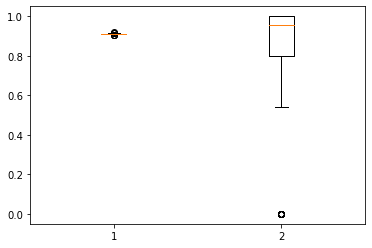

In [25]:
plt.boxplot(np.array(f1_metrics))
plt.show()
